In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1)

In [2]:
# Load high-risk employees and costs
high_risk = pd.read_csv('../data/processed/high_risk_employees.csv')
costs = pd.read_csv('../data/processed/attrition_costs.csv')
employee_data = pd.read_csv('../data/processed/employees_engineered.csv')

In [4]:
# Merge datasets
high_risk_detailed = pd.merge(
    high_risk,
    employee_data,
    on='EmployeeID',
    how='left'
)

# Merge with cost data
high_risk_detailed = pd.merge(
    high_risk_detailed,
    costs[['EmployeeID', 'TotalCost', 'ExpectedCost']],
    on='EmployeeID',
    how='left'
)

In [5]:
# Define key attrition factors and interventions based on SHAP analysis
intervention_strategies = {
    'Tenure/Experience': {
        'risk_factors': ['YearsSinceHire', 'YearsAtCompany'],
        'trigger_condition': 'employee["YearsSinceHire"] < 2',
        'intervention': 'Structured onboarding and first-year experience program',
        'description': 'Enhance early-career engagement through a structured first-year experience including mentorship, quarterly check-ins, skill development plans, and enhanced orientation.',
        'cost_per_employee': 5_000_000,  # IDR
        'success_rate': 0.65  # 65% reduction in attrition risk
    },
    'Commute/Location': {
        'risk_factors': ['DistanceFromHome'],
        'trigger_condition': 'employee["DistanceFromHome"] > 15',
        'intervention': 'Flexible work arrangements',
        'description': 'Offer hybrid work options, flexible hours, or transportation subsidies to reduce commute burden.',
        'cost_per_employee': 8_000_000,  # IDR
        'success_rate': 0.70
    },
    'Engagement': {
        'risk_factors': ['EngagementScore', 'JobSatisfaction'],
        'trigger_condition': 'employee["EngagementScore"] < 3.5 or employee["JobSatisfaction"] < 3',
        'intervention': 'Personalized engagement plan',
        'description': 'Create individual engagement plans with career conversations, project alignment to interests, and recognition opportunities.',
        'cost_per_employee': 4_000_000,  # IDR
        'success_rate': 0.55
    },
    'Compensation': {
        'risk_factors': ['SalaryRatioToLevel', 'SalaryRatioDept'],
        'trigger_condition': 'employee["SalaryRatioToLevel"] < 0.9 or employee["SalaryRatioDept"] < 0.9',
        'intervention': 'Compensation adjustment',
        'description': 'Targeted salary adjustment to align with internal and external benchmarks, along with benefits review.',
        'cost_per_employee': 25_000_000,  # IDR (annual increase)
        'success_rate': 0.80
    },
    'Performance/Recognition': {
        'risk_factors': ['PerformanceRating'],
        'trigger_condition': 'employee["PerformanceRating"] >= 4',
        'intervention': 'High performer retention program',
        'description': 'Specialized development program for high performers including stretch assignments, leadership exposure, and advanced training.',
        'cost_per_employee': 15_000_000,  # IDR
        'success_rate': 0.75
    },
    'Work-Life Balance': {
        'risk_factors': ['WorkLifeBalance', 'Overtime'],
        'trigger_condition': 'employee["WorkLifeBalance"] < 3 or employee["Overtime"] == True',
        'intervention': 'Workload rebalancing',
        'description': 'Workload assessment, resource allocation review, and wellness program enrollment.',
        'cost_per_employee': 6_000_000,  # IDR
        'success_rate': 0.60
    }
}

# Function to determine appropriate interventions for each employee
def identify_interventions(employee, strategies):
    """Identify which interventions would benefit this employee based on risk factors"""
    recommended_interventions = []
    
    for strategy_name, strategy in strategies.items():
        # Check if the trigger condition applies
        if eval(strategy['trigger_condition']):
            # Calculate ROI
            intervention_cost = strategy['cost_per_employee']
            attrition_cost = employee['TotalCost']
            risk_reduction = strategy['success_rate']
            current_risk = employee['AttritionProbability']
            
            # Expected value without intervention
            expected_cost_without = current_risk * attrition_cost
            
            # Expected value with intervention
            new_risk = current_risk * (1 - risk_reduction)
            expected_cost_with = new_risk * attrition_cost + intervention_cost
            
            # Calculate ROI and savings
            savings = expected_cost_without - expected_cost_with
            roi = savings / intervention_cost if intervention_cost > 0 else 0
            
            recommended_interventions.append({
                'EmployeeID': employee['EmployeeID'],
                'Strategy': strategy_name,
                'Intervention': strategy['intervention'],
                'Description': strategy['description'],
                'CurrentRisk': current_risk,
                'RiskReduction': risk_reduction,
                'NewRisk': new_risk,
                'InterventionCost': intervention_cost,
                'PotentialSavings': savings,
                'ROI': roi,
                'Priority': 'High' if roi > 2 else ('Medium' if roi > 1 else 'Low')
            })
    
    return recommended_interventions


Top Intervention Strategies by Expected Savings:
                         EmployeeCount    AvgROI   TotalCost  TotalSavings
Strategy                                                                  
Engagement                         159  9.051369   636000000  5.756671e+09
Tenure/Experience                   91  8.330398   455000000  3.790331e+09
Work-Life Balance                   95  6.625604   570000000  3.776594e+09
Commute/Location                    60  5.232320   480000000  2.511514e+09
Compensation                       118  0.832150  2950000000  2.454842e+09
Performance/Recognition             46  2.414360   690000000  1.665908e+09


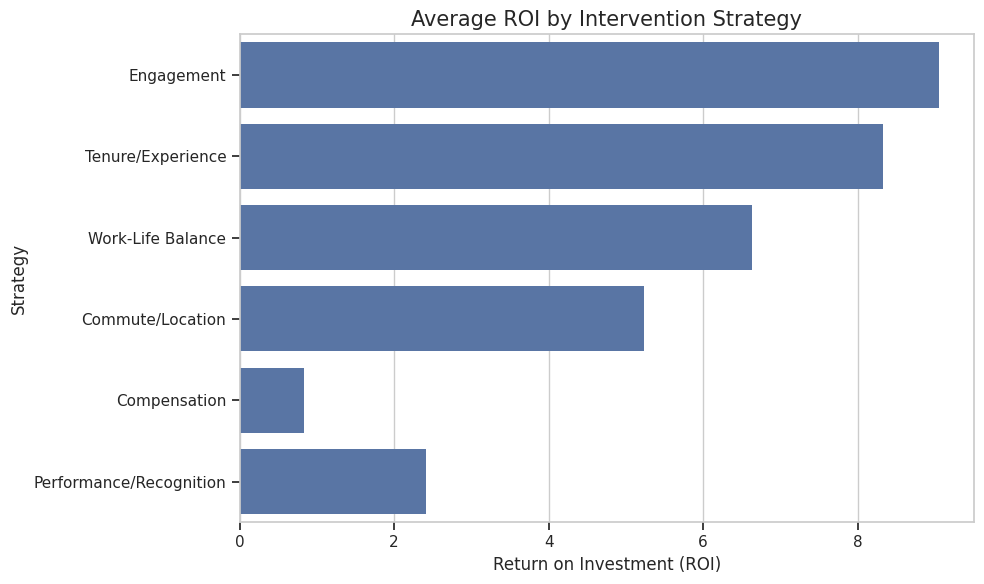

In [6]:
# Apply intervention identification to high-risk employees
all_interventions = []
for _, employee in high_risk_detailed.iterrows():
    interventions = identify_interventions(employee, intervention_strategies)
    all_interventions.extend(interventions)

# Create interventions DataFrame
interventions_df = pd.DataFrame(all_interventions)

# Calculate department-level intervention strategies
dept_interventions = interventions_df.groupby(['Strategy']).agg(
    EmployeeCount=('EmployeeID', 'nunique'),
    AvgROI=('ROI', 'mean'),
    TotalCost=('InterventionCost', 'sum'),
    TotalSavings=('PotentialSavings', 'sum')
).sort_values('TotalSavings', ascending=False)

# Display results
print("Top Intervention Strategies by Expected Savings:")
print(dept_interventions)

# Plot ROI by intervention type
plt.figure(figsize=(10, 6))
sns.barplot(x='AvgROI', y=dept_interventions.index, data=dept_interventions)
plt.title('Average ROI by Intervention Strategy', fontsize=15)
plt.xlabel('Return on Investment (ROI)')
plt.tight_layout()
plt.show()

# Save intervention plans for dashboard
interventions_df.to_csv('../data/processed/intervention_plans.csv', index=False)

In [7]:
interventions_df

,EmployeeID,Strategy,Intervention,Description,CurrentRisk,RiskReduction,NewRisk,InterventionCost,PotentialSavings,ROI,Priority
0,10081,Engagement,Personalized engagement plan,Create individual engagement plans with career...,0.716670,0.55,0.322502,4000000,3.722413e+07,9.306033,High
1,10081,Work-Life Balance,Workload rebalancing,"Workload assessment, resource allocation revie...",0.716670,0.60,0.286668,6000000,3.897178e+07,6.495296,High
2,10084,Tenure/Experience,Structured onboarding and first-year experienc...,Enhance early-career engagement through a stru...,0.684967,0.65,0.239739,5000000,1.123701e+05,0.022474,Low
3,10084,Engagement,Personalized engagement plan,Create individual engagement plans with career...,0.684967,0.55,0.308235,4000000,3.258516e+05,0.081463,Low
4,10084,Compensation,Compensation adjustment,Targeted salary adjustment to align with inter...,0.684967,0.80,0.136993,25000000,-1.870785e+07,-0.748314,Low
...,...,...,...,...,...,...,...,...,...,...,...
564,13845,Compensation,Compensation adjustment,Targeted salary adjustment to align with inter...,0.600466,0.80,0.120093,25000000,-1.948409e+07,-0.779364,Low
565,13846,Engagement,Personalized engagement plan,Create individual engagement plans with career...,0.633163,0.55,0.284923,4000000,3.242062e+07,8.105155,High
566,13847,Tenure/Experience,Structured onboarding and first-year experienc...,Enhance early-career engagement through a stru...,0.633817,0.65,0.221836,5000000,3.808701e+07,7.617402,High
567,13847,Engagement,Personalized engagement plan,Create individual engagement plans with career...,0.633817,0.55,0.285218,4000000,3.245824e+07,8.114559,High


### Explaining the Intervention Strategies Results

The intervention analysis results you're seeing represent the outcome of our financial modeling of different retention strategies. Let me break down what each column means and what the results tell us:

#### Column Explanations
- **EmployeeCount**: Number of employees identified as candidates for each intervention
- **AvgROI**: Average Return on Investment (expected savings divided by intervention cost)
- **TotalCost**: The full cost to implement this intervention for all identified employees
- **TotalSavings**: Expected financial benefit from reduced attrition

#### Strategy Insights

1. **Engagement (ROI: 9.05)**
   - This strategy shows the highest return on investment, suggesting that improving employee engagement is the most cost-effective approach
   - Targeting 159 employees with relatively low-cost interventions (4M IDR per employee on average)
   - Likely includes personalized development plans, project alignment with interests, and recognition programs
   - The high ROI indicates that employees leave primarily due to engagement issues that can be addressed affordably

2. **Tenure/Experience (ROI: 8.33)**
   - Second highest ROI, focused on 91 newer employees
   - Confirms what we saw in the SHAP analysis where Years Since Hire was a top factor
   - Suggests structured onboarding, mentorship, and first-year experience programs would be highly effective
   - The moderate cost (5M IDR per employee) delivers substantial returns

3. **Work-Life Balance (ROI: 6.63)**
   - Strong ROI targeting 95 employees experiencing imbalance or overwork
   - Especially important for roles with high overtime identified in our analysis
   - Cost of 6M IDR per employee is reasonable compared to the attrition risk it addresses

4. **Commute/Location (ROI: 5.23)**
   - Moderate-high ROI targeting 60 employees with long commutes
   - Reinforces the importance of the Distance From Home factor we saw in SHAP analysis
   - Interventions likely include flexible work arrangements or transportation support

5. **Compensation (ROI: 0.83)**
   - Lowest ROI but still essential component of a comprehensive strategy
   - Targets 118 employees who are likely underpaid relative to market or internal benchmarks
   - High cost per employee (25M IDR on average) explains the lower ROI
   - Despite lower ROI, still generates substantial savings through retention of key talent

6. **Performance/Recognition (ROI: 2.41)**
   - Moderate ROI targeting 46 employees (likely high performers)
   - Higher cost per employee (15M IDR) but justified for retaining top talent
   - Important because high performers generate disproportionate value and are targeted by competitors

### Strategic Implications

The analysis reveals that while compensation matters, non-monetary factors like engagement, structured early career experiences, and work-life balance deliver much higher ROI for retention. This aligns with modern HR research showing that salary alone doesn't drive retention without these supporting elements.

A comprehensive retention strategy would include elements from all six categories, but with investment prioritized based on ROI. The recommended approach would be to implement the high-ROI engagement and early tenure programs first, while planning for targeted compensation adjustments for the most critical talent.